In [1]:
import numpy as np

from IPython.display import HTML
import matplotlib.pyplot as plt
import matplotlib.collections as mc
from matplotlib.animation import FuncAnimation
from matplotlib.animation import ArtistAnimation
from matplotlib.patches import Rectangle
from mpl_toolkits.mplot3d import Axes3D
from pathlib import Path
import pandas as pd
import pickle
import seaborn as sns


## Figure: Constant Model Grid Search

- 5-fold cross-validation. dataset size = 40. training size = 20. 5-fold sizes = {train: 16, test: 4}
- scores are mean validation fitness across all 5 folds.

In [2]:
# Load the results of the GridSearchCV
with open('real_results/grid_search_exp_dataset1/results_model_constant_rep_0', 'rb') as fh:
    rc = pickle.load(fh)

FileNotFoundError: [Errno 2] No such file or directory: 'real_results/grid_search_exp_dataset1/results_model_constant_rep_0'

- What are the best parameters?
- What is the distribution of scores?

In [ ]:
rc['best_params']

In [ ]:
mutpbs = gs_model.cv_results_['param_mutpb'].data
cxpbs = gs_model.cv_results_['param_cxpb'].data
scores = gs_model.cv_results_['mean_test_score']
stds = gs_model.cv_results_['std_test_score']
mutpbs, cxpbs, scores, stds

### Plot fitness of each hyperparameter

In [ ]:
def plot_hyperparams(mutpbs, cxpbs, scores):
    plt.plot(mutpbs, scores, '.')
    plt.title('mutation rate vs fitness')
    plt.xlabel('mutation rate')
    plt.ylabel('score')
    plt.show()

    plt.plot(cxpbs, scores, '.')
    plt.title('crossover rate vs fitness')
    plt.xlabel('crossover rate')
    plt.ylabel('score')
    plt.show()

    best_i = np.argmax(scores)
    print(f'best cxpb: {cxpbs[best_i]}, best mutpb: {mutpbs[best_i]}, best score: {scores[best_i]}')


    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    ax.plot_surface(mutpbs.reshape(11, 11), cxpbs.reshape(11, 11), scores.reshape(11, 11), cmap='Greens')
    ax.set_xlabel('mutpb')
    ax.set_ylabel('cxpb')
    ax.set_zlabel('fitness')
    plt.show()

    cdf = pd.DataFrame({'mutpb': mutpbs, 'cxpb': cxpbs, 'fitness': scores, 'std': stds})
    mutmeans = cdf.groupby('mutpb').mean()
    cxmeans = cdf.groupby('cxpb').mean()
    plt.plot(mutmeans.index, mutmeans['fitness'], '.')
    plt.title('mutation rate vs mean fitness across all crossover rates')
    plt.xlabel('mutation rate')
    plt.ylabel('score')
    plt.show()

    plt.plot(cxmeans.index, cxmeans['fitness'], '.')
    plt.title('crossover rate vs mean fitness across all mutation rates')
    plt.xlabel('crossover rate')
    plt.ylabel('score')
    plt.show()
    


In [3]:
plot_hyperparams(mutpbs, cxpbs, scores)

# described by JJ as a line of splattering drops. This is the raindrop distribution.

NameError: name 'plot_hyperparams' is not defined

## Figure: Logistic Model Grid Search



In [4]:
mutpbs = []
cxpbs = []
scores = []
files = []
for p in Path('real_results/dataset1_gse2').glob('*_rep_0_*'):
#     print(p)
    with open(p, 'rb') as fh:
        rl = pickle.load(fh)
        mutpbs.append(rl['mutpb'])
        cxpbs.append(rl['cxpb'])
        scores.append(rl['test_fitness'])
        files.append(str(p.name))
      
mutpbs = np.array(mutpbs)
cxpbs = np.array(cxpbs)
scores = np.array(scores)
files = np.array(files)
mutpbs, cxpbs, scores, files

# the results come in from the filesystem in a disorganized fashion.
# arrange the results s.t. they are sorted by key=(cxpb, mutpb)
# This makes the 3d plot happy.
idx = np.argsort(mutpbs, kind='stable')
mutpbs = mutpbs[idx]
cxpbs = cxpbs[idx]
scores = scores[idx]
files = files[idx]
mutpbs, cxpbs, scores, files
idx = np.argsort(cxpbs, kind='stable')
mutpbs = mutpbs[idx]
cxpbs = cxpbs[idx]
scores = scores[idx]
files = files[idx]
mutpbs, cxpbs, scores, files


(array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64))

In [5]:
plot_hyperparams(mutpbs, cxpbs, scores)

NameError: name 'plot_hyperparams' is not defined

## Figure: Experiment 1: Fitness vs Generation

In [14]:
# load results
def load_exp_results(dn='real_results/dataset1_exp1', model_type='constant', sort=True):
    rs = []
    for p in Path(dn).glob(f'results_model_{model_type}_rep_*'):
        with open(p, 'rb') as fh:
            rs.append(pickle.load(fh))
            
    if sort:
        return list(sorted(rs, key=lambda r: r['i_rep']))
    else:
        return rs


In [15]:
lrs = load_exp_results(dn='real_results/dataset_exp1', model_type='logistic')
crs = load_exp_results(dn='real_results/dataset_exp1', model_type='constant')
blrs = load_exp_results(dn='real_results/dataset_exp1', model_type='balanced_logits')
gprs = load_exp_results(dn='real_results/dataset_exp1', model_type='gp')

In [11]:

def rs_to_gen_max_fits(rs):
    """
    :return: ndarray, shape=(n_rep, n_gen), of the max fitness of the population each generation.
    """
    n_rep = len(rs)
    n_gen = max(len(r['log'].chapters['fitness']) for r in rs)
    max_fits = np.full((n_rep, n_gen), np.nan)
    for i_rep in range(n_rep):
        for i_gen in range(n_gen):
            max_fits[i_rep, i_gen] = rs[i_rep]['log'].chapters['fitness'][i_gen]['max']

    return max_fits


def rs_to_gen_avg_sizes(rs):
    """
    :return: ndarray, shape=(n_rep, n_gen), of the average size of the population each generation.
    """
    n_rep = len(rs)
    n_gen = max(len(r['log'].chapters['fitness']) for r in rs)
    avg_sizes = np.full((n_rep, n_gen), np.nan)
    for i_rep in range(n_rep):
        for i_gen in range(n_gen):
            avg_sizes[i_rep, i_gen] = rs[i_rep]['log'].chapters['size'][i_gen]['avg']

    return avg_sizes


def rs_to_gen_max_sizes(rs):
    """
    :return: ndarray, shape=(n_rep, n_gen), of the average size of the population each generation.
    """
    n_rep = len(rs)
    n_gen = max(len(r['log'].chapters['fitness']) for r in rs)
    sizes = np.full((n_rep, n_gen), np.nan)
    for i_rep in range(n_rep):
        for i_gen in range(n_gen):
            sizes[i_rep, i_gen] = rs[i_rep]['log'].chapters['size'][i_gen]['max']

    return sizes


def rs_to_fitnesses(rs):
    """
    :return: ndarray, shape=(n_rep, n_eval), of the fitness of each fitness evaluation from each repetition.
    """
    n_rep = len(rs)
    n_eval = max(len(r['fitnesses']) for r in rs)  # note: different reps will have different # of evals
    vals = np.full((n_rep, n_eval), np.nan)  # shape: (n_rep, n_eval)
    for i_rep in range(n_rep):
        fitnesses = rs[i_rep]['fitnesses']
        vals[i_rep, :len(fitnesses)] = fitnesses
        
    return vals
    

def rs_to_fitness(rs, kind='train'):
    """
    :param dataset_type: 'train', 'test', 'future_train' or 'future_test'
    :return: ndarray, shape=(n_rep,), of the 'train_fitness' of each result.
    """
    key = kind + '_fitness'
    return nd.array([r[key] for r in rs])


def analyze_exp_results(rs, model_type='logistic'):
    """
    :param rs: list of result dicts, one result per repetition
    """
    n_rep = len(rs)
    n_gen = max(len(r['log'].chapters['fitness']) for r in rs)
    model_type = rs[0]['model_type']
    
    # collect statistics
    max_fits = np.full((n_rep, n_gen), np.nan)
    avg_sizes = np.full((n_rep, n_gen), np.nan)
    for i_rep in range(n_rep):
        for i_gen in range(n_gen):
            max_fits[i_rep, i_gen] = rs[i_rep]['log'].chapters['fitness'][i_gen]['max']
            avg_sizes[i_rep, i_gen] = rs[i_rep]['log'].chapters['size'][i_gen]['avg']

    # plot mean and std max fitness per generation
    mean_max_fits = max_fits.mean(axis=0)
    std_max_fits = max_fits.std(axis=0)
    plt.errorbar(np.arange(n_gen), mean_max_fits, std_max_fits)
    plt.title(f'{model_type.capitalize()} Model Fitness vs Generation')
    plt.xlabel('generation')
    plt.ylabel(f'mean and sd of IoU across {n_rep} reps')
    plt.show()
    
    
def plot_figure_fit_vs_eval(model_rss, model_types, path=None):    
    fig, ax = plt.subplots(figsize=(8,6), dpi=200)
    set_plot_font_sizes()
    for rs, model_type in zip(model_rss, model_types):
        n_rep = len(rs)
#         print('n_rep', n_rep)
        # plot mean and std max fitness per generation
        fitnesses = rs_to_fitnesses(rs)
#         print('fitnesses.shape', fitnesses.shape)
        n_eval = fitnesses.shape[1]
#         print('n_eval', n_eval)
        mean_fits = np.nanmean(fitnesses, axis=0)
        std_fits = np.nanstd(fitnesses, axis=0)
#         print('mean_fits.shape', mean_fits.shape)
#         print('std_fits.shape', std_fits.shape)
#         print('mean_fits[:10]', mean_fits[:10])
#         print('std_fits[:10]', std_fits[:10])
#         print('mean_fits[100:110]', mean_fits[100:110])
#         print('std_fits[100:110]', std_fits[100:110])
        evals = np.arange(n_eval)
#         print('n_eval', n_eval)
        p = plt.plot(evals, mean_fits, '.', alpha=0.1)
        plot_color = p[0].get_color()  # e.g. 'b'
#         plt.errorbar(evals, mean_fits, std_fits, marker='.', linestyle='', label=model_type, alpha=0.1)
#         evals = np.tile(evals, (n_rep, 1))
#         plt.plot(evals, fitnesses, '.', label=model_type, alpha=0.2)

        # plot a trend line (looks better when printing in black and white)
        # average groups of n evaluations
        n_group = 100
        trend_max_idx = len(mean_fits) // n_group * n_group
        trend_fit = mean_fits[:trend_max_idx].reshape(-1, n_group).mean(axis=1)
        trend_eval = (evals[:trend_max_idx].reshape(-1, n_group).mean(axis=1) + 0.5).astype(int)
        plt.plot(trend_eval, trend_fit, c=plot_color, label=model_type)
        
    plt.title(f'Fitness vs Evaluations')
    plt.xlabel('evaluation count')
    plt.ylabel(f'mean fitness across {n_rep} reps')
    plt.legend()
    if path is not None:
        plt.savefig(path)
        
    plt.show()


def set_plot_font_sizes():
    SMALL_SIZE = 12
    MEDIUM_SIZE = 14
    BIGGER_SIZE = 20

    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('axes', titlesize=BIGGER_SIZE)    # title size
    
    
def plot_figure_fit_vs_gen(model_rss, model_types, path=None):    
    fig, ax = plt.subplots(figsize=(8,6), dpi=200)
    set_plot_font_sizes()
    prev_n_rep = None
    for rs, model_type in zip(model_rss, model_types):
        n_rep = len(rs)
        print(model_type, n_rep)
        if prev_n_rep is None:
            prev_n_rep = n_rep
        elif prev_n_rep != n_rep:
            raise Exception('n_rep different for different models')
            
        # plot mean and std max fitness per generation
        n_gen = max(len(r['log'].chapters['fitness']) for r in rs)
        max_fits = rs_to_gen_max_fits(rs)
        mean_max_fits = max_fits.mean(axis=0)
        std_max_fits = max_fits.std(axis=0)
        plt.errorbar(np.arange(n_gen), mean_max_fits, std_max_fits, label=model_type, alpha=0.5)
        
    plt.title(f'Fitness vs Generation')
    plt.xlabel('generation')
    plt.ylabel(f'mean and sd of IoU across {n_rep} reps')
    plt.legend(loc='upper left')
    if path is not None:
        plt.savefig(path)
        
    plt.show()

    


In [ ]:
plot_figure_fit_vs_gen([crs, lrs, gprs], ('constant', 'logistic', 'gp'), path='figures/fig_exp1_fit_vs_gen.png')
plot_figure_fit_vs_eval([crs, lrs, gprs], ('constant', 'logistic', 'gp'), path='figures/fig_exp1_fit_vs_eval.png')

## Figure: Fitness Boxplot

In [ ]:
def plot_figure_fitness_boxplot(crs, lrs, blrs, gprs, path=None):
    n_rep = len(crs)
    print(len(crs), len(lrs), len(blrs))
    if not (n_rep == len(crs) and n_rep == len(lrs) and n_rep == len(blrs) and n_rep == len(gprs)):
        raise Exception('all results lists should have the same length. ' +
                        f'len(crs), len(lrs), len(blrs) len(gprs) = {len(crs), len(lrs), len(blrs), len(gprs)}')
    
    def extract(rs):
        fit_train = np.array([rs[i]['train_fitness'] for i in range(n_rep)])
        fit_test = np.array([rs[i]['test_fitness'] for i in range(n_rep)])
        fit_future_train = np.array([rs[i]['future_train_fitness'] for i in range(n_rep)])
        fit_future_test = np.array([rs[i]['future_test_fitness'] for i in range(n_rep)])
        return fit_train, fit_test, fit_future_train, fit_future_test
    
    c_fit_train, c_fit_test, c_fit_future_train, c_fit_future_test = extract(crs)
    l_fit_train, l_fit_test, l_fit_future_train, l_fit_future_test = extract(lrs)
    bl_fit_train, bl_fit_test, bl_fit_future_train, bl_fit_future_test = extract(blrs)
    gp_fit_train, gp_fit_test, gp_fit_future_train, gp_fit_future_test = extract(gprs)

    # get data in tidy form prefered by seaborn
    n_model = 4
    no_future = True
    if no_future:
        n_dataset = 2
        fitnesses = np.hstack([
            c_fit_train, c_fit_test, 
            gp_fit_train, gp_fit_test,
            l_fit_train, l_fit_test, 
            bl_fit_train, bl_fit_test,
        ])
        datasets = np.tile(np.repeat(['train', 'test', ], n_rep), n_model)
    else:
        n_dataset = 4
        fitnesses = np.hstack([
            c_fit_train, c_fit_test, c_fit_future_train, c_fit_future_test,
            gp_fit_train, gp_fit_test, gp_fit_future_train, gp_fit_future_test,
            l_fit_train, l_fit_test, l_fit_future_train, l_fit_future_test,
            bl_fit_train, bl_fit_test, bl_fit_future_train, bl_fit_future_test,
        ])
        datasets = np.tile(np.repeat(['train', 'test', 'future_train', 'future_test'], n_rep), n_model)
        
    models = np.repeat(['constant', 'gp', 'logistic', 'true'], n_rep * n_dataset)
    reps = np.tile(np.arange(n_rep), n_dataset * n_model)
    df = pd.DataFrame({'model': models, 'dataset': datasets, 
                       'fitness': fitnesses, 'rep': reps})

    fig, ax = plt.subplots(figsize=(8,6), dpi=200)
    ax = sns.boxplot(x="dataset", y="fitness", hue="model",
                     data=df, palette="Set3", ax=ax)
    plt.title('Fitness Comparison')
    if path is not None:
        plt.savefig(path)

    plt.show()
#     fig, ax = plt.subplots(2, 2, figsize=(8,6))
#     ax[0,0].boxplot([c_fit_train, l_fit_train, bl_fit_train])
#     ax[0,1].boxplot([c_fit_test, l_fit_test, bl_fit_test])
#     ax[1,0].boxplot([c_fit_future_train, l_fit_future_train, bl_fit_future_train])
#     ax[1,1].boxplot([c_fit_future_test, l_fit_future_test, bl_fit_future_test])
#     plt.show()
    
    
    

In [8]:
plot_figure_fitness_boxplot(crs, lrs, blrs, gprs, path='figures/fig_exp1_fitness_comparison.png')

NameError: name 'plot_figure_fitness_boxplot' is not defined

## Experiment: Variance of IoU score

Our test set performance in the Fitness Comparison Figure is better than our training set performance. This is concerning to people who see it. Is this because the test set is easy or is something else going on?


In [9]:
vrs = load_exp_results(dn='results_variance/dataset100', model_type='balanced_logits', sorted=False)
vrs0 = vrs[0]

NameError: name 'set_plot_font_sizes' is not defined

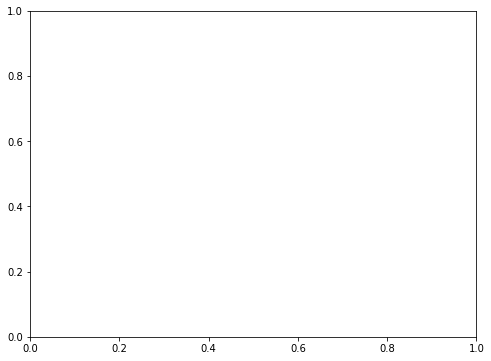

In [10]:
vrs0
final_fits = vrs0['final_fits']
val_fits = final_fits[1:]
n_val = len(val_fits)
if 'batch_size' in vrs0:
    batch_size = vrs0['batch_size']
else:
    batch_size = 10
model_type = vrs0['model_type']

fig, ax = plt.subplots(figsize=(8,6))
set_plot_font_sizes()
plt.axhline(y=final_fits[0], label='train fitness')  # training 
plt.boxplot(final_fits[1:])
plt.legend()
plt.title(f'{model_type.capitalize()} Fitness\n for {n_val} Reps, batch_size={batch_size}')
plt.xticks([1], ['test set'])
plt.ylabel('fitness')
plt.show()

## Figure: Experiment 1 Size vs Generation

In [23]:
def plot_figure_size_vs_gen(rs, model_type, path=None):
    fig, ax = plt.subplots(figsize=(8,6), dpi=200)
    set_plot_font_sizes()
    prev_n_rep = None
    
    n_rep = len(rs)
    print(model_type, n_rep)
    if prev_n_rep is None:
        prev_n_rep = n_rep
    elif prev_n_rep != n_rep:
        raise Exception('n_rep different for different models')

    # plot mean and std max size per generation
    n_gen = max(len(r['log'].chapters['size']) for r in rs)
    max_sizes = rs_to_gen_max_sizes(rs)
    avg_sizes = rs_to_gen_avg_sizes(rs)
    mean_max_sizes = max_sizes.mean(axis=0)
    std_max_sizes = max_sizes.std(axis=0)
    mean_avg_sizes = avg_sizes.mean(axis=0)
    std_avg_sizes = avg_sizes.std(axis=0)
    plt.errorbar(np.arange(n_gen), mean_max_sizes, std_max_sizes, label=f'max size', alpha=0.5)
    plt.errorbar(np.arange(n_gen), mean_avg_sizes, std_avg_sizes, label=f'avg size', alpha=0.5)
        
    plt.title(f'{model_type.upper()} Tree Size vs Generation')
    plt.xlabel('generation')
    plt.ylabel(f'mean and sd of size across {n_rep} reps')
    plt.legend(loc='upper left')
    if path is not None:
        plt.savefig(path)
        
    plt.show()

    


gp 16


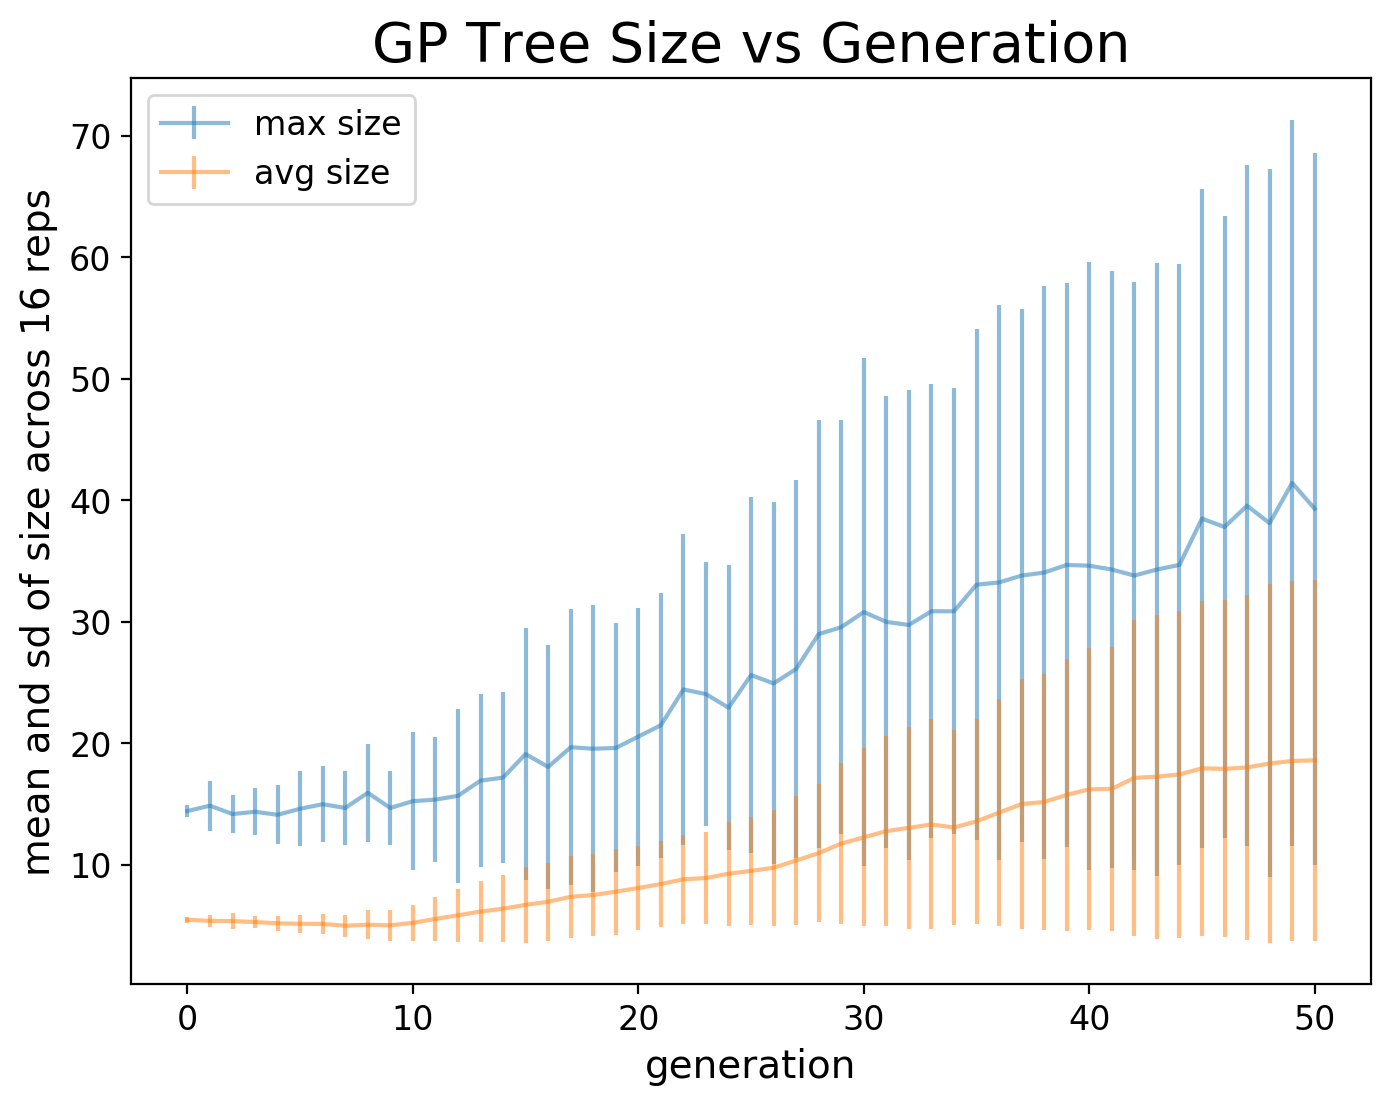

In [24]:
lrs = load_exp_results(dn='real_results/dataset_exp1', model_type='logistic')
crs = load_exp_results(dn='real_results/dataset_exp1', model_type='constant')
blrs = load_exp_results(dn='real_results/dataset_exp1', model_type='balanced_logits')
gprs = load_exp_results(dn='real_results/dataset_exp1', model_type='gp')

plot_figure_size_vs_gen(gprs, model_type='gp', path='figures/fig_exp1_size_vs_gen.png')


### What are the expressions of the best individuals of all the GP repetitions?

In [37]:
df = pd.DataFrame([(r['i_rep'], r['test_fitness'], r['best_ind']['expr']) for r in gprs], 
                  columns=['i_rep', 'test_fitness', 'expr'])
df['expr_size'] = df['expr'].apply(lambda x: len(x.replace('(', ' ').replace(',', ' ').strip().split()))
with pd.option_context('display.max_colwidth', -1):  # more options can be specified also
    display(df)

,i_rep,test_fitness,expr,expr_size
0,0,0.712609,"mul(add(-0.3208158974494586, dz), dz)",5
1,1,0.630864,"protectedDiv(sub(cos(sin(dz)), dz), protectedDiv(sub(protectedDiv(sub(sub(cos(protectedDiv(sub(cos(3.804421633867058), mul(wind, wind)), sub(-5.838690136027993, sin(0.37561586021435)))), dz), sub(hum, 0.05367530425336987)), sub(-5.838690136027993, sin(dz))), sub(sub(cos(protectedDiv(sub(cos(3.804421633867058), mul(wind, sin(wind))), sub(-5.838690136027993, sin(0.37561586021435)))), dz), dz)), neg(dz)))",50
2,2,0.728919,"sub(dz, sin(sin(sin(sin(dz)))))",7
3,3,0.788631,"mul(mul(dz, dz), mul(dz, mul(mul(dz, wind), dz)))",11
4,4,0.732776,"add(protectedDiv(sin(-0.5196270866741285), 0.9556095905534739), dz)",6
5,5,0.698384,"mul(mul(dz, mul(dz, dz)), dz)",7
6,6,0.732832,"protectedDiv(sub(cos(protectedDiv(cos(add(dz, cos(dz))), add(sin(sub(cos(5.889962226010406), neg(hum))), dz))), add(add(dz, add(dz, dz)), dz)), neg(protectedDiv(dz, add(sin(neg(dz)), dz))))",32
7,7,0.743068,"mul(cos(cos(protectedDiv(cos(add(dz, dz)), dz))), add(-0.3783614642079181, dz))",12
8,8,0.723941,"mul(dz, sub(dz, cos(protectedDiv(add(sub(dz, wind), dz), cos(sub(add(sub(dz, cos(sub(add(dz, sub(add(dz, protectedDiv(add(dz, add(dz, sub(temp, 1.7899608363777226))), hum)), sin(dz))), sin(dz)))), dz), protectedDiv(cos(sub(add(cos(sin(dz)), add(mul(hum, -2.0270987615319713), sin(0.7736932943432993))), temp)), hum)))))))",52
9,9,0.789659,"mul(wind, mul(dz, mul(cos(0.6915006597009228), mul(mul(0.7702156606048673, dz), dz))))",12


### What are the expressions of the best individuals of all the LOGISTIC repetitions?

In [38]:
df = pd.DataFrame([(r['i_rep'], r['test_fitness'], r['best_ind']) for r in lrs], 
                  columns=['i_rep', 'test_fitness', 'best_ind'])
with pd.option_context('display.max_colwidth', -1):  # more options can be specified also
    display(df)

,i_rep,test_fitness,best_ind
0,0,0.802716,"[-3.8849298171589526, 5.248631626868609, 0.10395799418468021, 0.42488854545683374, 0.4358218064662363]"
1,1,0.709013,"[-3.1225356668531297, 6.611601207008999, 0.21468701045825384, 0.6543033511250331, 0.14285963168504637]"
2,2,0.799322,"[-5.509200842451793, 7.404291524770669, 0.11867869938578568, 0.4170718138220182, 0.6891105121200699]"
3,3,0.729291,"[-5.408681745671605, 8.947201240992893, 0.5097049778026417, 1.0477420449664079, 1.0843098918231278]"
4,4,0.789818,"[-6.826811722560055, 5.874123517093449, 0.3854072397918277, 0.50058235380381, 1.582603724472704]"
5,5,0.772368,"[-3.295849905082841, 5.949155387321188, -0.04641757786679286, 0.5230496910007412, 0.765221677409667]"
6,6,0.793247,"[-6.485181637998154, 7.074243460992079, 0.4914979349729165, 0.6371939289382028, 0.9209134212338705]"
7,7,0.765051,"[-3.8840138657569874, 4.978357676923873, 0.2010404324679842, 0.4040842423469093, 0.05776238746482376]"
8,8,0.821348,"[-5.95248396882696, 6.0443094320293165, 0.19640230922328872, 0.36353784253309274, 1.0066061963786566]"
9,9,0.696279,"[-2.844221322313387, 4.770517232713062, 0.04108819980482385, 0.441253586645435, 0.9439909162805239]"
